In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import cv2
import os.path
import numpy as np
from utils.depth_manager import *
import urllib.request
from PIL import Image

In [3]:
TFLITE_FILE_PATH = 'model/midas_v2_1_small.tflite'

if not os.path.isfile(TFLITE_FILE_PATH):
    tflite_model_url = "https://tfhub.dev/intel/lite-model/midas/v2_1_small/1/lite/1?lite-format=tflite"
    urllib.request.urlretrieve(tflite_model_url, TFLITE_FILE_PATH)

In [4]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details

[{'name': 'Const',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([  1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [5]:
output_details

[{'name': 'midas_net_custom/sequential/re_lu_9/Relu',
  'index': 335,
  'shape': array([  1, 256, 256,   1]),
  'shape_signature': array([  1, 256, 256,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# Infer interpreter on a single image

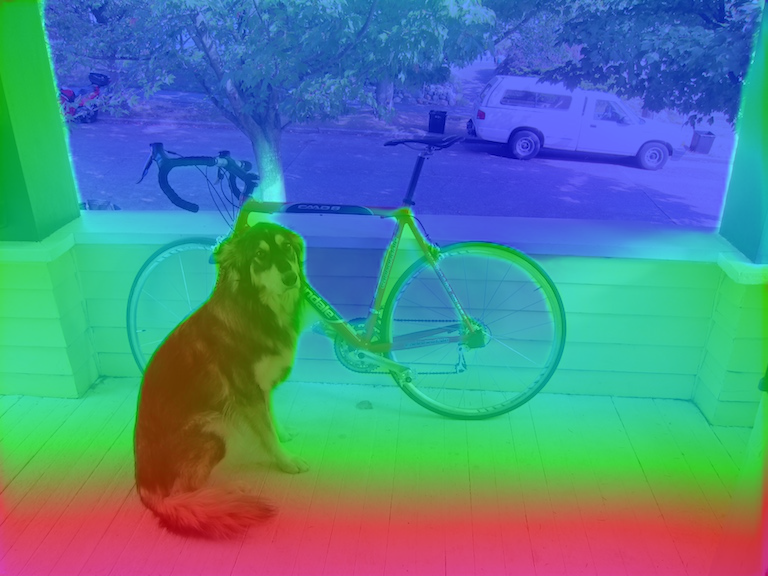

In [9]:
# Get input image
img = cv2.imread('images/dog.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# preprocess input image
input_data = preprocess_image(rgb_img, [256, 256])

# reshape data according to input_details
input_data = tf.transpose(input_data, [0, 2, 3, 1])

# Get result
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# post processing
output_data = np.squeeze(output_data, axis=0)
overlap, _ = overlap_img_with_segmap(rgb_img, output_data)

image = Image.fromarray(overlap)
image.save("images/dog_depthEstimation_tflite.png")
image

# Infer interpreter on a video or a livestream

In [14]:
# to reduce the output gif size,
# keep one frame every two and divide by two the resolution
keep_every=2
resize_fact=0.5
output_gif = "images/person_dog_depthEstimation_tflite.gif"

cap = cv2.VideoCapture("images/person_dog.mp4")
number_of_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
imgs = []
for i in tqdm(range(number_of_frame)):
    if i%keep_every != 0 and keep_every != 1:
        continue
    _, image = cap.read()
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # preprocess input image
    input_data = preprocess_image(rgb_img, [256, 256])

    # reshape data according to input_details
    input_data = tf.transpose(input_data, [0, 2, 3, 1])

    # Get result
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # post processing
    output_data = np.squeeze(output_data, axis=0)
    overlap, _ = overlap_img_with_segmap(rgb_img, output_data)
    image = Image.fromarray(overlap)
    image = image.resize((int(image.size[0]*resize_fact),
                          int(image.size[1]*resize_fact)))
    imgs.append(image)

imgs[0].save(output_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)
gif = imageio.mimread(output_gif, memtest=False)
imageio.mimsave(output_gif, gif, fps=30)

100%|████████████████████████████████████████████████████████████████████████████████| 371/371 [01:02<00:00,  5.93it/s]
